This notebook was made during our training with [ShAI](https://www.kaggle.com/competitions/shai-ml/overview).  
Public Scoreboard: 73.50689  
Private Scoreboard: 27.92218   
Using Random Forest

# Contents
* [1. Import Necessary Libraries](#import-libraries)
* [2. Import the Data and Understand its Features](#import-data)
* [3. Exploratory Data Analysis (EDA)](#eda)
    - [3.1 Univariate Analysis](#uni)
    - [3.2 Multivariate Analysis](#multi)
* [4. Data Cleaning & Preprocessing](#data-preprocessing)
* [5. Feature Engineering](#feature-engineering)
* [6. Models Experiments](#models)

<a id="import-libraries"></a>
# 1. Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn. linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

<a id="import-data"></a>
# 2. Import the Data and Understand its Features

In [2]:
# reading from csv files
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# renaming column 'unnamed: 0' to 'id'
train_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
test_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

# storing the id's of test dataframe to use it later for submission
ids = test_df.id

In [3]:
train_df.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
1,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
2,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
3,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
4,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47


Features:
- Content price price in US dollars (\$326--\$18,823)

- carat weight of the diamond (0.2--5.01)

- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

- color diamond colour, from J (worst) to D (best)

- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

- x length in mm (0--10.74)

- y width in mm (0--58.9)

- z depth in mm (0--31.8)

- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

- table width of top of diamond relative to widest point (43--95)

In [4]:
print("Shape of train df: {}, and of test df: {}".format(train_df.shape, test_df.shape))

Shape of train df: (43040, 11), and of test df: (10900, 10)


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43040 entries, 0 to 43039
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       43040 non-null  int64  
 1   carat    43040 non-null  float64
 2   cut      43040 non-null  object 
 3   color    43040 non-null  object 
 4   clarity  43040 non-null  object 
 5   depth    43040 non-null  float64
 6   table    43040 non-null  float64
 7   price    43040 non-null  int64  
 8   x        43040 non-null  float64
 9   y        43040 non-null  float64
 10  z        43040 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       10900 non-null  int64  
 1   carat    10900 non-null  float64
 2   cut      10900 non-null  object 
 3   color    10900 non-null  object 
 4   clarity  10900 non-null  object 
 5   depth    10900 non-null  float64
 6   table    10900 non-null  float64
 7   x        10900 non-null  float64
 8   y        10900 non-null  float64
 9   z        10900 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 851.7+ KB


In [7]:
train_df.describe()

,id,carat,depth,table,price,x,y,z
count,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000,43040.000000
mean,26758.804554,0.796964,61.746080,57.439542,3942.706343,5.724376,5.728122,3.534367
std,15484.904515,0.481455,1.435246,2.240196,4023.534556,1.132496,1.159641,0.714543
min,2.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13326.750000,0.380000,61.000000,56.000000,940.000000,4.660000,4.670000,2.870000
50%,26824.500000,0.710000,61.800000,57.000000,2388.000000,5.710000,5.720000,3.530000
75%,40290.250000,1.030000,62.500000,59.000000,5309.250000,6.500000,6.500000,4.020000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Really interesting!, our data is clean,there are no missing values, no negative values in these features.  
We might delete x, y, z with zero values, also check for outliers.    
We can jump directly to Exploratory Data Anaylsis (EDA).

<a id="eda"></a>
# 3. Exploratory Data Analysis (EDA)

I love to seperate the variables into categorical and numerical, in our scenario:
- Categorical: `clarity`, `color`, and `cut`.
- Numerical: `carat`, `depth`, `table`, `x`, `y`, `z`, `price`.

Keep in mind that the dependant variable is `price`, which we are going to predict later on.

In [8]:
# splitting our data into categorical and numerical
categorical_df = train_df[['clarity', 'color', 'cut']]
numerical_df = train_df[['carat', 'depth', 'table', 'x', 'y', 'z', 'price']]

<a id="uni"></a>
### 3.1 Univariate Analysis

In [9]:
def barplot_percentage(data, column, title="", slice=12):
    """
    this function does a barplot graph with percentage
    
    :param data: dataframe you want to use
    :param column: column name
    :param title: title you could provide
    :param slice: how much you want to show in the graph
    :return None
    """
    # number of rows
    total = data.shape[0]

    f, ax = plt.subplots(figsize=(14, 8))
    ax = sns.barplot(data[column].value_counts()[: slice].index, data[column].value_counts()[: slice])
    #ax = sns.countplot(data[column])
    ax.set_title(title)

    # Adding percentage to the bars
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{percentage}', (x + width/2, y + height*1.02), ha='center')

    plt.ylabel("Count")
    plt.show()

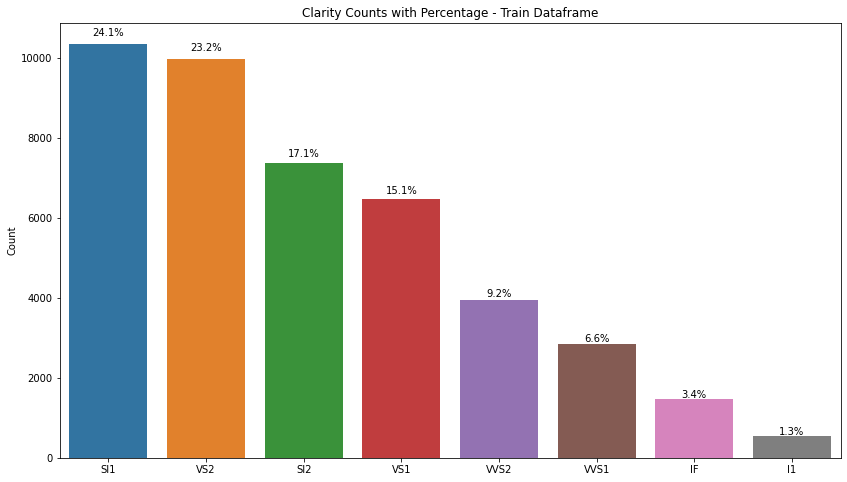

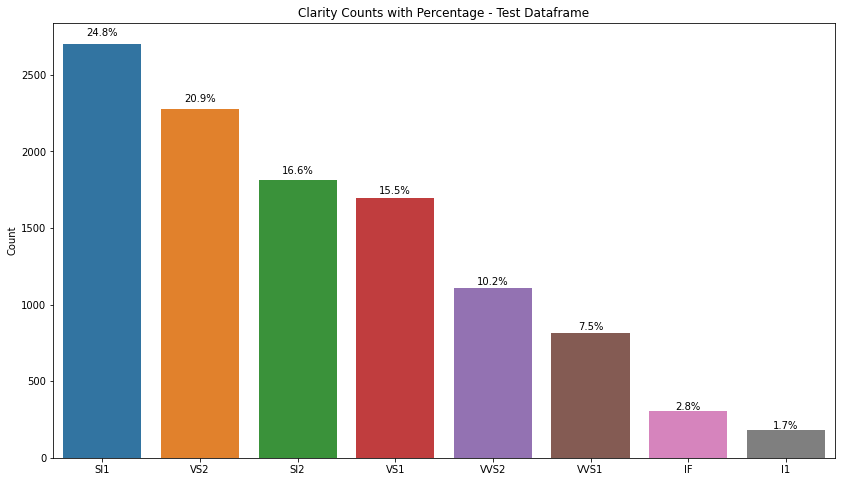

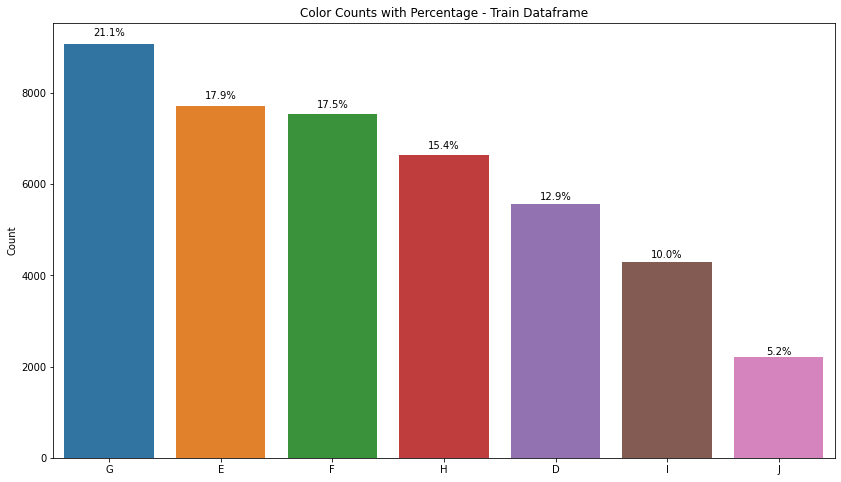

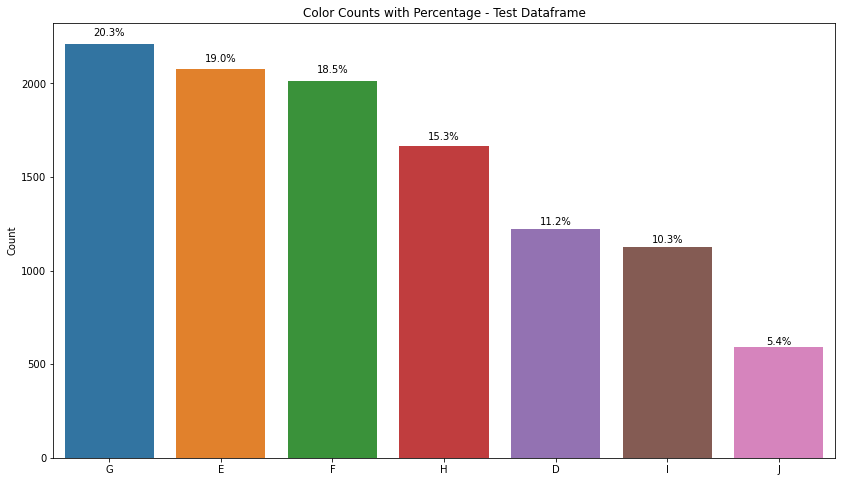

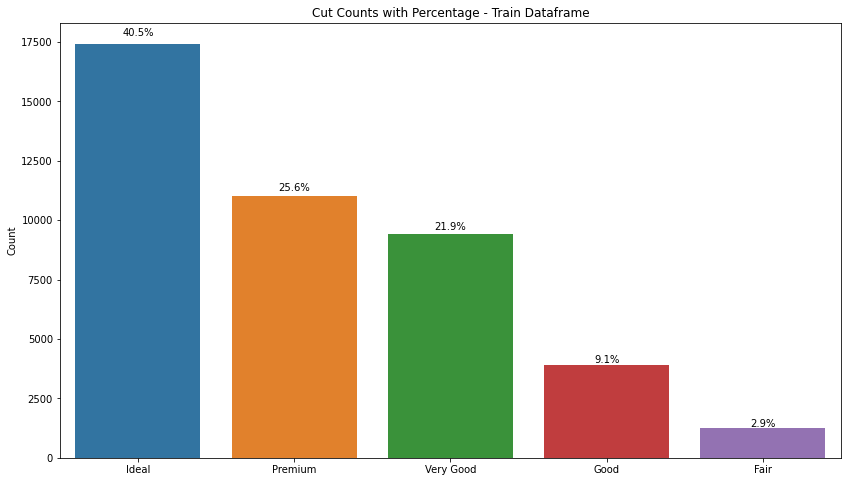

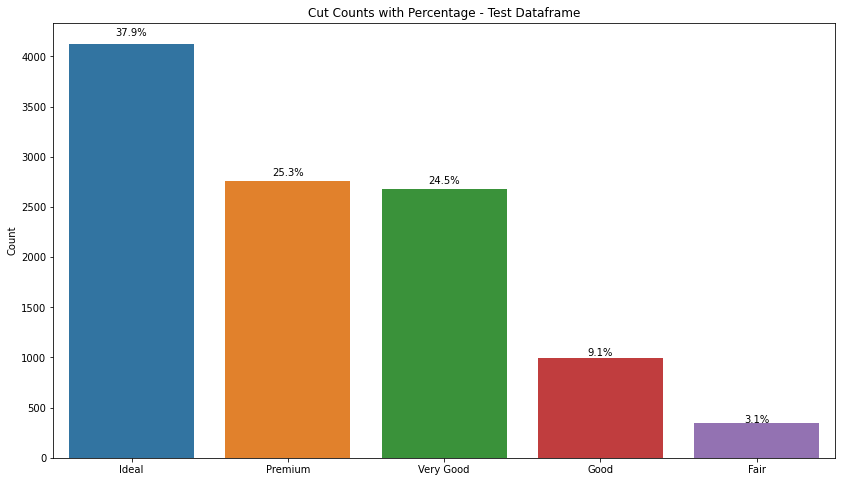

In [10]:
cate_titles = ['Clarity Counts with Percentage', 'Color Counts with Percentage', 'Cut Counts with Percentage']
for i, col in enumerate(categorical_df.columns):
    barplot_percentage(categorical_df, col, cate_titles[i] + " - Train Dataframe")
    barplot_percentage(test_df, col, cate_titles[i] + " - Test Dataframe")

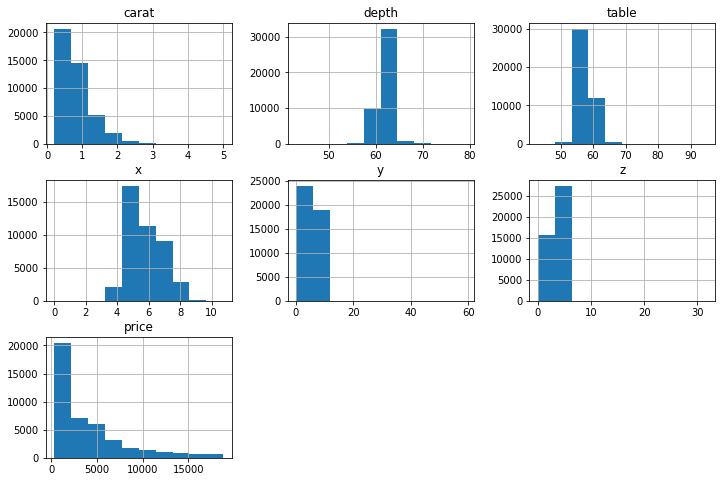

In [11]:
numerical_df.hist(figsize=(12, 8));

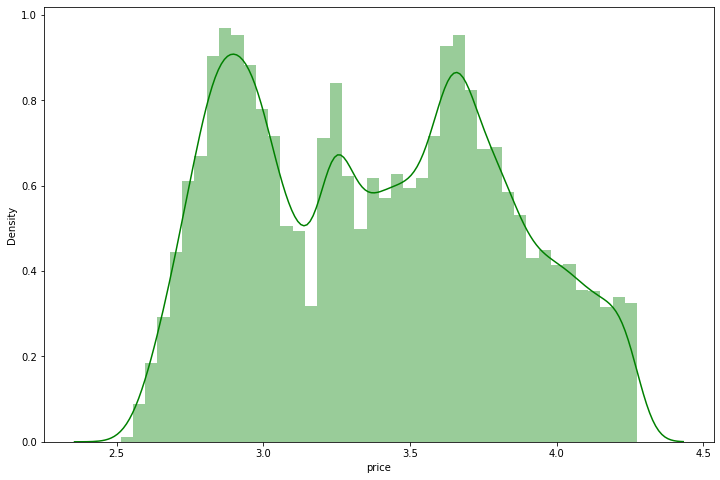

In [12]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log10(train_df['price']), kde=True, color = 'g')
plt.show()

**Insights**:
- `color`: G, E, F, H are the most colors.
- `cut`: the most cut is ideal, follows it premium, very good.
- `clarity`: SI1, SI2, VS2, VS1 are the most clarity.

<a id="multi"></a>
### 3.2 Multivariate Analysis

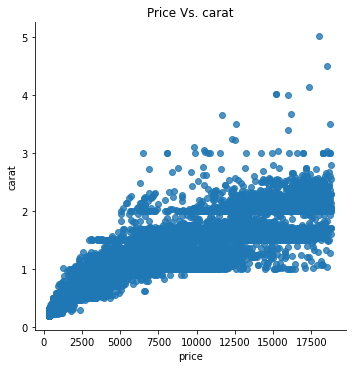

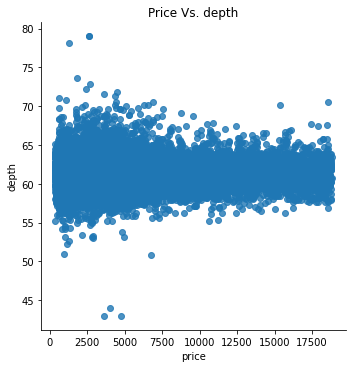

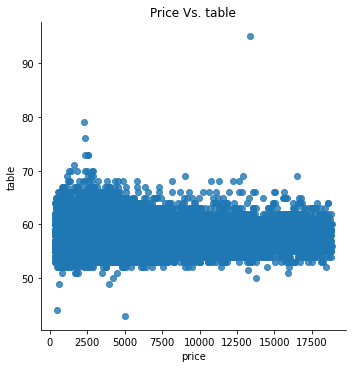

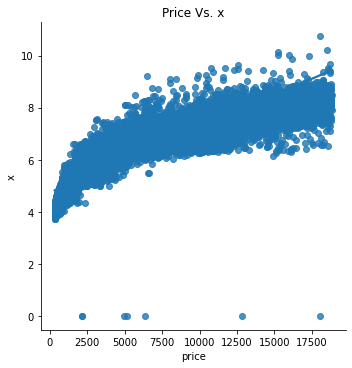

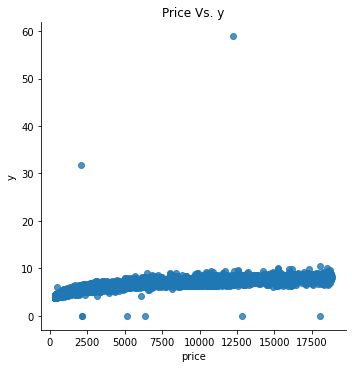

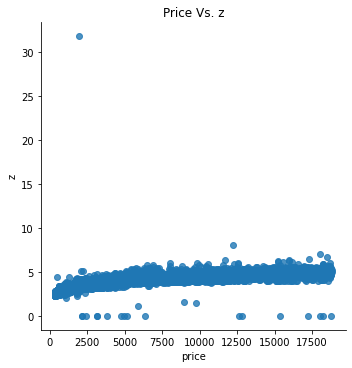

In [13]:
for col in numerical_df.columns:
    if col == "price":
        continue
    #f, ax = plt.subplots(figsize=(12, 8))
    ax = sns.lmplot(data=train_df, x='price', y=col)
    plt.title("Price Vs. {}".format(col))
    plt.show()

There are outliers we are going to remove

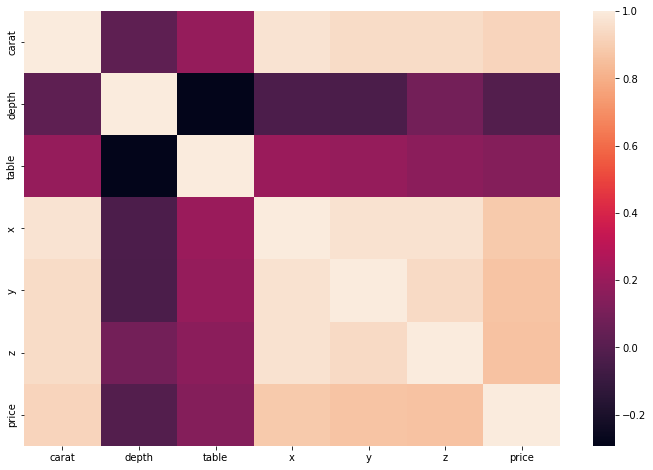

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr());

We can see there that `x`, `y`, `z`, `carat` are correlated to our dependant variable `price`.

<a id="data-preprocessing"></a>
# 4. Data Cleaning & Preprocessing

In [15]:
# Removing the datapoints having min 0 value in either x, y or z features
# this cell was taken from https://www.kaggle.com/code/karnikakapoor/diamond-price-prediction/notebook
# train_df = train_df.drop(train_df[train_df["x"]==0].index)
# train_df = train_df.drop(train_df[train_df["y"]==0].index)
# train_df = train_df.drop(train_df[train_df["z"]==0].index)

# replacing 0 values by their median
train_df['x'].replace(0, train_df['x'].median())
train_df['y'].replace(0, train_df['y'].median())
train_df['z'].replace(0, train_df['z'].median())
train_df.shape

(43040, 11)

In [16]:
# Dropping the outliers (since we have huge dataset) by defining appropriate measures across features 
# this cell was taken from https://www.kaggle.com/code/karnikakapoor/diamond-price-prediction/notebook
train_df = train_df[(train_df["depth"] < 75) & (train_df["depth"] > 45)]
train_df = train_df[(train_df["table"] < 80) & (train_df["table"] > 40)]
train_df = train_df[(train_df["x"]<40)]
train_df = train_df[(train_df["y"]<40)]
train_df = train_df[(train_df["z"]<40)&(train_df["z"]>2)]


# replacing outliers with median
# train_df['x'].where(train_df['x'] >= 40, train_df.x.median(), inplace=True)
# train_df['y'].where(train_df['y'] >= 40, train_df.y.median(), inplace=True)
# train_df['z'].where(train_df['z'] >= 40, train_df.z.median(), inplace=True)
# train_df['z'].where(train_df['z'] <= 2, train_df.z.median(), inplace=True)

# train_df['depth'].where(train_df['depth'] >= 75, train_df.depth.median(), inplace=True)
# train_df['depth'].where(train_df['depth'] <= 45, train_df.depth.median(), inplace=True)
# train_df['table'].where(train_df['table'] >= 80, train_df.table.median(), inplace=True)
# train_df['table'].where(train_df['table'] <= 40, train_df.table.median(), inplace=True)

In [17]:
# converting the categorical variables `clarity`, `color`, `Cut` into numerical
# using label encoder

encoded_train = train_df.copy()
encoded_test = test_df.copy()
le = LabelEncoder()

for col in categorical_df.columns:
    encoded_train[col] = le.fit_transform(encoded_train[col])
    encoded_test[col] = le.fit_transform(encoded_test[col])

# drop id column since it's insignificant
# encoded_train.drop('id', axis=1, inplace=True)
# encoded_test.drop('id', axis=1, inplace=True)

In [18]:
X_train = encoded_train.drop('price', axis=1)
y_train = encoded_train.price

X_test = encoded_test

In [19]:
X_train.columns

Index(['id', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y',
       'z'],
      dtype='object')

<a id="feature-engineering"></a>
# 5. Feature Engineering

In [20]:
# I will be using polynomial features which makes combination of our features.
poly = PolynomialFeatures(2)

poly_train = poly.fit_transform(X_train)
poly_test = poly.fit_transform(X_test)

In [21]:
# simple volume of diamond x * y * z
train_df['volume'] = (train_df.x + train_df.y * train_df.z)
test_df['volume'] = (test_df.x * test_df.y * test_df.z) 

<a id="models"></a>
# 6. Models Experiments

In [22]:
# making a submission 
def save_submission(ids, predictions, file_name):
    """
    this function takes ids, predictionss and file_name
    and save a submission file in submission folder
    :p ids: ids which our first column
    :p predictions: the vlaue
    :p file_name: the csv file name you want

    :return: None
    """
    submission = pd.DataFrame({"Unnamed: 0": ids, "price": predictions})
    submission.to_csv("submissions//{}.csv".format(file_name), index=False)

In [23]:
# Building pipelins of standard scaler and model for varios regressors.

pipeline_lr = Pipeline([("scalar1", StandardScaler()),
                     ("lr", LinearRegression())])

pipeline_lasso = Pipeline([("scalar2", StandardScaler()),
                      ("lasso", Lasso())])

pipeline_dt = Pipeline([("scalar3", StandardScaler()),
                     ("dt", DecisionTreeRegressor())])

pipeline_rf=Pipeline([("scalar4", StandardScaler()),
                     ("rf", RandomForestRegressor())])

pipeline_kn=Pipeline([("scalar5", StandardScaler()),
                     ("kn", KNeighborsRegressor())])

pipeline_xgb=Pipeline([("scalar6", StandardScaler()),
                     ("xgb", XGBRegressor())])

pipeline_gbr=Pipeline([("scalar7", StandardScaler()),
                     ("gbr", GradientBoostingRegressor())])


# List of all the pipelines
pipelines = [pipeline_lr, pipeline_lasso, pipeline_dt, pipeline_rf, pipeline_kn, pipeline_xgb, pipeline_gbr]

# Dictionary of pipelines and model types for ease of reference
pipeline_dict = {0: "LinearRegression", 1: "Lasso", 2: "DecisionTree", 3: "RandomForest", 4: "KNeighbors", 5: "XGBRegressor", 6: "GradientBoostingRegressor"}

# Fit the pipelines
for i, pipe in enumerate(pipelines):
    # fitting our data
    pipe.fit(X_train, y_train)

    # getting the name of our model
    model_name = pipeline_dict[i]

    print("{} -> score: {}".format(model_name, pipe.score(X_train, y_train)))

    # predictions
    predictions = pipe.predict(X_test)

    # saving our predictions as csv file for submission
    save_submission(ids, predictions, model_name)

LinearRegression -> score: 0.886952946666338
Lasso -> score: 0.8869298672853985
DecisionTree -> score: 1.0
RandomForest -> score: 0.9999491819440084
KNeighbors -> score: 0.9823165050294393
XGBRegressor -> score: 0.9999506221791968
GradientBoostingRegressor -> score: 0.9973540615980988


In [24]:
# # saving our random forest model
# # save the model to disk
import joblib
filename = 'rf_pipeline.sav'
joblib.dump(pipeline_rf, filename)

['rf_pipeline.sav']

These models are overfitted.  
Let's use cross validation with 10 folds to validate our models.

In [139]:
# this cell takes approximately 2 mins to run
cv_results_rms = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train, y_train, cv=10)
    cv_results_rms.append(cv_score)
    print("{}: {}".format(pipeline_dict[i], cv_score.mean()))

LinearRegression: -6.600693771050759
Lasso: -5.5169619647725225
DecisionTree: 0.6846824166743573
RandomForest: 0.7189523359791954
KNeighbors: 0.3367508798399129
XGBRegressor: 0.7114424303950764
GradientBoostingRegressor: 0.5188608720823205


XGBRegressor had performed the best, then random forest, we can try submitting the both.  
Now let's try using polynomial features.

In [ ]:
# this cell takes approximately 2 minutes to run
# Building pipelins of standard scaler and model for varios regressors using polynomial featuress
# pipeline_lr = Pipeline([("scalar1", StandardScaler()),
#                      ("lr", LinearRegression())])

# pipeline_lasso = Pipeline([("scalar2", StandardScaler()),
#                       ("lasso", Lasso())])

# pipeline_dt = Pipeline([("scalar3", StandardScaler()),
#                      ("dt", DecisionTreeRegressor())])

# # pipeline_rf=Pipeline([("scalar4", StandardScaler()),
# #                      ("rf", RandomForestRegressor())])


# pipeline_kn=Pipeline([("scalar5", StandardScaler()),
#                      ("kn", KNeighborsRegressor())])


# pipeline_xgb=Pipeline([("scalar6", StandardScaler()),
#                      ("xgb", XGBRegressor())])

# # List of all the pipelines
# pipelines = [pipeline_lr, pipeline_lasso, pipeline_dt, pipeline_kn, pipeline_xgb]

# # Dictionary of pipelines and model types for ease of reference
# pipeline_dict = {0: "LinearRegression_Poly", 1: "Lasso_Poly", 2: "DecisionTree_Poly", 3: "KNeighbors_Poly", 4: "XGBRegressor_Poly"}

# # Fit the pipelines
# for i, pipe in enumerate(pipelines):
#     # fitting our data
#     pipe.fit(poly_train, y_train)

#     # getting the name of our model
#     model_name = pipeline_dict[i]

#     print("{} -> score: {}".format(model_name, pipe.score(poly_train, y_train)))

#     # predictions
#     predictions = pipe.predict(poly_test)

#     # saving our predictions as csv file for submission
#     #save_submission(ids, predictions, model_name)

LinearRegression_Poly -> score: 0.9325964943815388
Lasso_Poly -> score: 0.9285725776949765
DecisionTree_Poly -> score: 0.9999943564242939
KNeighbors_Poly -> score: 0.9795911019018382
XGBRegressor_Poly -> score: 0.9928113387707977


In [ ]:
# this cell takes approximately 4 mins to run
# I've ran this cell once with Random forest, see the results down below.
# cv_results_rms = []
# for i, model in enumerate(pipelines):
#     cv_score = cross_val_score(model, poly_train, y_train, cv=10)
#     cv_results_rms.append(cv_score)
#     print("{}: {}".format(pipeline_dict[i], cv_score.mean()))

LinearRegression_Poly: -32.80345212047065
Lasso_Poly: -0.43038566512282656
DecisionTree_Poly: 0.23506815491101243
KNeighbors_Poly: 0.16155349158711135
XGBRegressor_Poly: 0.6403308941150722


**Scores are based on RMSE**
- XGBRegresssor --> 548.66669
- RandomForest --> 541.76029
- DecisionTree --> 748.52836
- XGBRegresssor Poly --> 572.934
- RandomForest Poly --> 818.74  
So doing polynomial features was not much of a help.  
Our RandomForest has scored better than XGBRegressor in the leaderboard, but this may change since the leaderboard is jsut 60% of the data.